In [38]:
import pandas as pd
import string
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

#### 1. Parse Roscom

In [39]:
## find id
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]

urls = []

for page in tqdm(range(1, 200), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/199 [00:00<?, ?it/s]

In [40]:
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))
    soup = BeautifulSoup(res.text)

    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/995 [00:00<?, ?it/s]

In [41]:
import csv

questions_list = question

csv_file = 'save/questions.csv'

with open(csv_file, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    writer.writerow(['Question'])

    for question_text in questions_list:
            writer.writerow([question_text])

print(f'successfully {csv_file}')

successfully save/questions.csv


In [42]:
csv_file = 'save/questions.csv'

data = pd.read_csv(csv_file, index_col='Question')
data.reset_index(inplace=True)
data.head(4)

,Question
0,Добрый день! 2 месяца назад были куплены авто ...
1,Здравствуйте!\r\nХотела бы получить правовую к...
2,Добрый день. Прошу разобраться в отношении зак...
3,19 октября 2023 года я выписала товар в Wildbe...


In [43]:
data.size

995

#### 2. Preprocessing

In [44]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from multiprocessing import Pool
from pymystem3 import Mystem
import pymorphy2

In [45]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grayni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargsp

In [46]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

<>:1: DeprecationWarning: invalid escape sequence '\w'
<>:1: DeprecationWarning: invalid escape sequence '\w'
C:\Users\grayni\AppData\Local\Temp\ipykernel_16504\3130366742.py:1: DeprecationWarning: invalid escape sequence '\w'
  words_regex = re.compile('\w+')


In [47]:
data['processed_question'] = list(tqdm(map(preprocess, data['Question']), total=len(data)))

  0%|          | 0/995 [00:00<?, ?it/s]

In [48]:
data.Question.iloc[4]

'Здравствуйте,такая ситуация произошла,13-го числа я внесла платно по кредитной карте тинькофф банка,13-го числа звонят моей сестре и говорят о том чтобы она мне передала чтобы я заплатила за кредитную карту называют сумму которую уже списали 13-го числа,потом 14-го числа звонят моей маме и говорят о том что у меня задолженность по кредитной карте,15-го числа я захожу в личный кабинет там написано что  все оплачено,нет никакой задолженность ,сегодня 21-го числа звонят опять моей маме и говорят,что если я не погашу долг придется платить моей маме,скинули реквизиты МОИ ,звонит мне мама в истерике и говорит что она должна платить мой кредит,ей так сказали,хотя мне никто не звонил,звонят почему то моим родным!Я хочу чтобы вы разобрались с вашими сотрудниками,на каком основании они звонят моим родственникам????Я буду подавать на вас в суд,пусть они с вами разбираются!я не давала согласия,о том что мои данные могут кому-то передавать!Отправлено с iPhone'

In [49]:
' '.join(data.processed_question.iloc[4])

'здравствуйте ситуация произойти число внести платно кредитный карта тинькофф банк число звонить сестра говорить передать заплатить кредитный карта называть сумма который списать число число звонить мама говорить задолженность кредитный карта число заходить личный кабинет написать всё оплатить никакой задолженность сегодня число звонить мама говорить погасить долг прийтись платить мама скинуть реквизит звонить мама истерика говорить должный платить кредит сказать хотя никто звонить звонить почему родный хотеть разобраться ваш сотрудник основание звонить родственник подавать суд пусть разбираться давать согласие дать мочь передавать отправить iphone'

In [50]:
from gensim.models import *
from gensim import corpora

In [51]:
dictionary = corpora.Dictionary(data.processed_question)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None)
dictionary.save('save/lenta.dict')

In [52]:
corpus = [dictionary.doc2bow(text) for text in data.processed_question]
corpora.MmCorpus.serialize('save/lenta.model', corpus)

In [53]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: total: 578 ms
Wall time: 574 ms


In [54]:
print(lda)

LdaModel<num_terms=935, num_topics=20, decay=0.5, chunksize=50>


In [55]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(6,
  '0.186*"документ" + 0.086*"запах" + 0.070*"поставщик" + 0.066*"домой" + 0.063*"заранее" + 0.061*"использование" + 0.054*"всё" + 0.054*"внимание" + 0.052*"предпринять" + 0.048*"наш"'),
 (7,
  '0.123*"день" + 0.081*"квартира" + 0.074*"акт" + 0.060*"добрый" + 0.058*"помещение" + 0.051*"весь" + 0.050*"работа" + 0.045*"этаж" + 0.042*"час" + 0.041*"ремонт"'),
 (16,
  '0.084*"ребёнок" + 0.048*"адрес" + 0.041*"продажа" + 0.037*"соответствие" + 0.036*"который" + 0.033*"результат" + 0.032*"это" + 0.028*"указать" + 0.027*"заказать" + 0.026*"прислать"'),
 (5,
  '0.253*"карта" + 0.202*"банк" + 0.085*"отменить" + 0.066*"руб" + 0.043*"покупать" + 0.037*"оплатить" + 0.023*"звонить" + 0.020*"пусть" + 0.020*"компания" + 0.020*"сумма"'),
 (15,
  '0.067*"право" + 0.046*"проверка" + 0.045*"просить" + 0.043*"данный" + 0.034*"потребитель" + 0.033*"обязать" + 0.032*"провести" + 0.032*"детский" + 0.030*"год" + 0.029*"счёт"'),
 (2,
  '0.082*"подсказать" + 0.072*"нарушение" + 0.070*"смартфон" + 0.067*"соо

In [56]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: total: 281 ms
Wall time: 2.02 s


In [57]:
print(lda.log_perplexity(corpus))

-9.726037700913936


In [58]:
print('Perplexy: ', np.exp(lda.log_perplexity(corpus)))

Perplexy:  5.969786540549749e-05


In [59]:
coherence_model_lda = CoherenceModel(model=lda, texts=data.processed_question, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Average coherence: ', coherence_lda)

Average coherence:  0.31989490599454573


In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/5 [00:00<?, ?it/s]

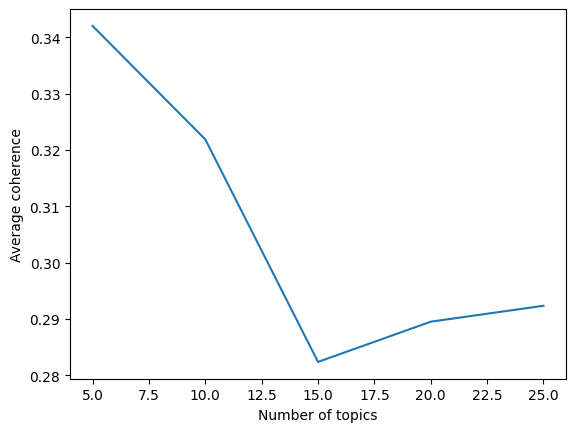

In [61]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data.processed_question, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Number of topics")
plt.ylabel("Average coherence")
plt.show()

In [62]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)